In [1]:
import json
from typing import List, Dict

import requests
from together import Together
from transformers import AutoTokenizer

/Users/vkuznetsov/my/deepschool_llm/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Предобработка входных данных

В данном задании мы будем ходить в онлайн модель. Предлагается все также ходить в together.ai, т.к. они дают $5 кредита при регистрации.

Вначале давайте руками поиграемся с API, посмотрим, как походы в API соотносятся с тем, что мы делали в домашнем задании "Доступные LLM"

In [2]:
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Meta-Llama-3.1-70B")

## Ручное форматирование промпта - 5 баллов

Давайте попробуем собрать вход для llama3.1 руками, для этого допишем функцию `format_messages_to_prompt`.
Она принимает messages - массив словарей, где указаны роли и текст сообщений, а возвращает она текст в формате, который нужно подать модели.

Например для истории сообщений

```python
messages = [
    {"role": "system", "content": "Some system message"},
    {"role": "user", "content": "This is a message from the user"},
    {"role": "assistant", "content": "this is a mesage from the assistant"}
]
```

должен выдаваться итоговый промпт

```text
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Some system message<|eot_id|><|start_header_id|>user<|end_header_id|>

This is a message from the user<|eot_id|><|start_header_id|>assistant<|end_header_id|>

this is a mesage from the assistant<|eot_id|>
```

Что важно:
1. Текст начинается со спецтокена bos
2. Дальше идет заголовок start_header_id + end_header_id, которые содержат роль
3. Дальше после \n\n идет текст, заканчивающийся на eot_id
4. Дальше следующий заголовок с новой ролью и т.д.

**Важно** - в данной функции нельзя использовать `tokenizer.apply_chat_template`

In [3]:
BEGIN_OF_TEXT_TOKEN = "<|begin_of_text|>"
END_OF_TEXT_TOKEN = "<|eot_id|>"
START_HEADER_ID_TOKEN = "<|start_header_id|>"
END_HEADER_ID_TOKEN = "<|end_header_id|>\n\n"

def format_messages_to_prompt(messages: List[Dict[str, str]]) -> str:
    def wrap_role(role: str) -> str:
        return START_HEADER_ID_TOKEN + role + END_HEADER_ID_TOKEN
    
    def wrap_message(content: str) -> str:
        return content + END_OF_TEXT_TOKEN

    result = BEGIN_OF_TEXT_TOKEN

    for message in messages:
        role: str = message["role"]
        content: str = message["content"]

        result += wrap_role(role)
        result += wrap_message(content)

    return result


messages = [
    {"role": "system", "content": "Some system message"},
    {"role": "user", "content": "This is a message from the user"},
    {"role": "assistant", "content": "this is a mesage from the assistant"}
]



reference_text = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Some system message<|eot_id|><|start_header_id|>user<|end_header_id|>

This is a message from the user<|eot_id|><|start_header_id|>assistant<|end_header_id|>

this is a mesage from the assistant<|eot_id|>"""


assert format_messages_to_prompt(messages) == reference_text

Мы также помним, что раньше у нас была `tokenizer.apply_chat_template`. Т.к. у нас неофициальный форк llama3.1, то chat_template в токенайзер нам не завезли, поэтому придется добавить его руками

In [4]:
chat_template = """
{{- bos_token }}
{%- if custom_tools is defined %}
    {%- set tools = custom_tools %}
{%- endif %}
{%- if not tools_in_user_message is defined %}
    {%- set tools_in_user_message = true %}
{%- endif %}
{%- if not date_string is defined %}
    {%- set date_string = "26 Jul 2024" %}
{%- endif %}
{%- if not tools is defined %}
    {%- set tools = none %}
{%- endif %}

{#- This block extracts the system message, so we can slot it into the right place. #}
{%- if messages[0]['role'] == 'system' %}
    {%- set system_message = messages[0]['content']|trim %}
    {%- set messages = messages[1:] %}
{%- else %}
    {%- set system_message = "" %}
{%- endif %}

{#- System message + builtin tools #}
{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}
{%- if builtin_tools is defined or tools is not none %}
    {{- "Environment: ipython\n" }}
{%- endif %}
{%- if builtin_tools is defined %}
    {{- "Tools: " + builtin_tools | reject('equalto', 'code_interpreter') | join(", ") + "\n\n"}}
{%- endif %}
{{- "Cutting Knowledge Date: December 2023\n" }}
{{- "Today Date: " + date_string + "\n\n" }}
{%- if tools is not none and not tools_in_user_message %}
    {{- "You have access to the following functions. To call a function, please respond with JSON for a function call." }}
    {{- 'Respond in the format {"name": function name, "parameters": dictionary of argument name and its value}.' }}
    {{- "Do not use variables.\n\n" }}
    {%- for t in tools %}
        {{- t | tojson(indent=4) }}
        {{- "\n\n" }}
    {%- endfor %}
{%- endif %}
{{- system_message }}
{{- "<|eot_id|>" }}

{#- Custom tools are passed in a user message with some extra guidance #}
{%- if tools_in_user_message and not tools is none %}
    {#- Extract the first user message so we can plug it in here #}
    {%- if messages | length != 0 %}
        {%- set first_user_message = messages[0]['content']|trim %}
        {%- set messages = messages[1:] %}
    {%- else %}
        {{- raise_exception("Cannot put tools in the first user message when there's no first user message!") }}
{%- endif %}
    {{- '<|start_header_id|>user<|end_header_id|>\n\n' -}}
    {{- "Given the following functions, please respond with a JSON for a function call " }}
    {{- "with its proper arguments that best answers the given prompt.\n\n" }}
    {{- 'Respond in the format {"name": function name, "parameters": dictionary of argument name and its value}.' }}
    {{- "Do not use variables.\n\n" }}
    {%- for t in tools %}
        {{- t | tojson(indent=4) }}
        {{- "\n\n" }}
    {%- endfor %}
    {{- first_user_message + "<|eot_id|>"}}
{%- endif %}

{%- for message in messages %}
    {%- if not (message.role == 'ipython' or message.role == 'tool' or 'tool_calls' in message) %}
        {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\n\n'+ message['content'] | trim + '<|eot_id|>' }}
    {%- elif 'tool_calls' in message %}
        {%- if not message.tool_calls|length == 1 %}
            {{- raise_exception("This model only supports single tool-calls at once!") }}
        {%- endif %}
        {%- set tool_call = message.tool_calls[0].function %}
        {%- if builtin_tools is defined and tool_call.name in builtin_tools %}
            {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' -}}
            {{- "<|python_tag|>" + tool_call.name + ".call(" }}
            {%- for arg_name, arg_val in tool_call.arguments | items %}
                {{- arg_name + '="' + arg_val + '"' }}
                {%- if not loop.last %}
                    {{- ", " }}
                {%- endif %}
                {%- endfor %}
            {{- ")" }}
        {%- else  %}
            {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' -}}
            {{- '{"name": "' + tool_call.name + '", ' }}
            {{- '"parameters": ' }}
            {{- tool_call.arguments | tojson }}
            {{- "}" }}
        {%- endif %}
        {%- if builtin_tools is defined %}
            {#- This means we're in ipython mode #}
            {{- "<|eom_id|>" }}
        {%- else %}
            {{- "<|eot_id|>" }}
        {%- endif %}
    {%- elif message.role == "tool" or message.role == "ipython" %}
        {{- "<|start_header_id|>ipython<|end_header_id|>\n\n" }}
        {%- if message.content is mapping or message.content is iterable %}
            {{- message.content | tojson }}
        {%- else %}
            {{- message.content }}
        {%- endif %}
        {{- "<|eot_id|>" }}
    {%- endif %}
{%- endfor %}
{%- if add_generation_prompt %}
    {{- '<|start_header_id|>assistant<|end_header_id|>\n\n' }}
{%- endif %}
""".strip()
tokenizer.chat_template = chat_template

## Автоматическая сборка промпта - 5 баллов

Давайте вспомним теперь на деле, как используется chat_template! Попробуем использовать функцию `tokenizer.apply_chat_template`

In [5]:
messages = [
    {"role": "system", "content": "Some system message"},
    {"role": "user", "content": "This is a message from the user"},
    {"role": "assistant", "content": "this is a mesage from the assistant"}
]

prompt = tokenizer.apply_chat_template(messages, tokenize=False)
prompt

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nSome system message<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nThis is a message from the user<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nthis is a mesage from the assistant<|eot_id|>'

In [6]:
reference_prompt = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

Some system message<|eot_id|><|start_header_id|>user<|end_header_id|>

This is a message from the user<|eot_id|><|start_header_id|>assistant<|end_header_id|>

this is a mesage from the assistant<|eot_id|>"""

assert prompt == reference_prompt

Обратите внимание, что в заданном chat_template указаны Cutting Knowledge Date, т.е. до данные до какого периода видела модели, и Today Date - захардкоженная дата текущего диалога.

**Вопрос, обязательно напишите свой ответ здесь!**
На что влияет аргумент `add_generation_prompt` в функции `tokenizer.apply_chat_template`? Зачем его использовать?

## Походы в API - 10 баллов

Теперь давайте посмотрим, как можно ходить в API. Для примера мы будем ходить в together.ai, который щедро предоставляет $5 всем зарегистрировавшимся. Вообще говоря различных провайдеров много, API у них у всех очень похожий, т.к. все мимикрируют под OpenAI.

In [7]:
# Вставьте свой ключ из https://api.together.ai/
API_KEY = "PASTE YOUR KEY HERE"

In [8]:
import os
from dotenv import load_dotenv

load_dotenv("../.env")

API_KEY = os.getenv("TOGETHER_API_KEY")
API_KEY

'7e4d7a84a878f57edba454784f16fc4aa46fac127ae9194fb64383234fd50dea'

Есть несколько способов сходить в API. Можно ходить напрямую через библиотеку **requests**. Допишите post запрос в `url` с данными `data` и заголовками `headers`. 

In [9]:
headers = {
    'Authorization': 'Bearer ' + API_KEY,
    'Content-Type': 'application/json',
}
url = "https://api.together.ai/v1/chat/completions"
messages = [
    {"role": "system", "content": "You are a helpful assistant"},
    {"role": "user", "content": "What is the capital of Britain?"}
]

data = {
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
    "messages": messages
}

response = requests.post(url, headers=headers, json=data)
model_answer = response.json()["choices"][0]["message"]["content"]
assert "london" in model_answer.lower()

Мы подали messages, дальше они каким-то образом собрались в promt и подались модели. Мы не знаем, какой промпт используется на стороне провайдера. Вспомним про Today Date из предыдущего пункта задания - использует ли его together? Обновляют ли они его сегодняшним днем или оставляют 26 июля? Если обновляют, то по какому часовому поясу?

Чтобы ответы на эти и многие другие вопросы не мучали нас по ночам, можно использовать prompt формат, а именно подать модели текст напрямую на генерацию. Давайте для этого используем `tokenizer.apply_chat_template`. Модель будет принимать текст ровно так, как вы его подадите, без каких-либо предобработок. Подумайте, нужно ли вам использовать аргумент `add_generation_prompt`?

Чтобы послать запрос напрямую, нужно в предыдущем запросе убрать messages, который представляет из себя список словарей, и послать поле prompt - строку с промптом для модели.

In [10]:
# Ответ
# Флаг add_generation_prompt добавляет тег начала ответа assistant, по идее его надо добавить иначе модель может продолжать промпт вопроса юзера

headers = {
    'Authorization': 'Bearer ' + API_KEY,
    'Content-Type': 'application/json',
}
url = "https://api.together.ai/v1/chat/completions"
messages = [
    {"role": "system", "content": "You are a helpful assistant"},
    {"role": "user", "content": "What is the capital of Britain?"}
]

prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

data = {
    "model": "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
    "messages": messages
}

response = requests.post(url, headers=headers, json=data)
model_answer = response.json()["choices"][0]["message"]["content"]
assert "london" in model_answer.lower() and "assistant" not in model_answer.lower()

## Клиент - 5 баллов

Теперь мы понимаем общую схему взаимодействия с провайдером - они предоставляют апи, куда можно посылать или промтп или историю диалога. При посылке промпта вся ответственность за формат ложится на нас, при посылке messages форматтинг происходит на стороне провайдера, но мы не всегда представляем, как он работает. Выбор в пользу того или иного варианта всегда остается на вас.

Мы использовали выше библиотеку requests, чтобы послать HTTP-запрос на сервера together, однако есть способ и проще - python client. Давайте познакомимся с ним поближе. Для этого давайте используем функцию `client.chat.completions.create`. Также давайте добавим опции сэмплинга, которые в этой функции поддержаны. Их можно посылать и в запросах через requests, но мы здесь и далее будем пользоваться клиентом.
* top_k = 100
* temperature = 0.5
* top_p = 0.9
* repetition_penalty = 1.05

In [11]:
client = Together(api_key=API_KEY)

In [12]:
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"
messages = [
    {"role": "system", "content": "You are a helpful assistant"},
    {"role": "user", "content": "What is the capital of Britain?"}
]

response = client.chat.completions.create(
    model=model_name,
    messages=messages,
    top_k=100,
    top_p=0.9,
    repetition_penalty=1.05,
    temperature=0.5
)

response_text = response.choices[0].message.content
assert "london" in response_text.lower()
response_text

'The capital of Britain, also known as the United Kingdom (UK), is London.'

Аналогично посылать просто prompt можно через `client.completions.create`.

## Tools - 5 баллов

Давайте теперь посмотрим, как можно использовать tools в связке с моделями. У нас есть функция, которая входит в базу данных и получает информацию о юзере. Базы данных, конечно же, у нас никакой нет, но у нас есть некоторая функция, которая эмулирует это поведение, так что давайте попробуем ее описать.


In [13]:
def get_user_info_from_db(person_name: str) -> Dict[str, str]:
    database = {
        "ilya": {
            "job": "Software Developer",
            "pets": "dog",
        },
        "farruh": {
            "job": "Senior Data & Solution Architect",
            "hobby": "travelling, hiking",
        },
        "timur": {
            "job": "DeepSchool Founder",
            "city": "Novosibirsk",
        }
    }
    no_info = {"err": f"No info about {person_name}"}
    return database.get(person_name.lower(), no_info)

print(get_user_info_from_db("Timur"))

{'job': 'DeepSchool Founder', 'city': 'Novosibirsk'}


Давайте попробуем описать эту функцию в формате json, чтобы модель могла ее увидеть!
Заполните поля в определении дальше

In [14]:
get_user_info_from_db_tool = {
    "type": "function",
    "function": {
        "name": "get_user_info_from_db",
        "description": "function returns available user info such as job title, city of residence or hobbies", # Напишите, что функция делает своими словами
        "parameters": {
            "type": "object",
            "properties": {
                "person_name": {
                    "type": "string",
                    "description": "User first name"# Опишите смысл аргумента
                }
            },
            "required": ["person_name"] # укажите обязательные аргументы для функции
        }
    }
}

Теперь давайте подадим это описание в `tokenizer.apply_chat_template`. Обратите внимание на его аргумент `tools`! Не забудьте `add_generation_prompt`, если он нужен.

In [15]:
messages = [
    {"role": "system", "content": "You are a helpful assistant"},
    {"role": "user", "content": "What do you know about Ilya?"}
]
prompt = tokenizer.apply_chat_template(conversation=messages, tokenize=False, add_generation_prompt=True, tools=[get_user_info_from_db_tool])
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Environment: ipython
Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a helpful assistant<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the following functions, please respond with a JSON for a function call with its proper arguments that best answers the given prompt.

Respond in the format {"name": function name, "parameters": dictionary of argument name and its value}.Do not use variables.

{
    "type": "function",
    "function": {
        "name": "get_user_info_from_db",
        "description": "function returns available user info such as job title, city of residence or hobbies",
        "parameters": {
            "type": "object",
            "properties": {
                "person_name": {
                    "type": "string",
                    "description": "User first name"
                }
            },
            "required": [
                "person_name"
            ]
    

Давайте пошлем наш запрос в модель. На выбор 2 модели, если не будет работать с 8b, то предлагается посылать в 70b.
Для данного запроса для 8b был подобран работающий `seed=9706540181089681000`, который можно подать в функцию.

Давайте воспользуемся `client.completions.create` для генерации ответа от модели.

In [16]:
model_8b = "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"
model_70b = "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"

In [17]:
seed=9706540181089681000

response_8b = client.completions.create(prompt=prompt, model=model_8b, seed=seed) # Ваш код здесь
response_70b = client.completions.create(prompt=prompt, model=model_70b) # Ваш код здесь

print(response_8b.choices[0].text)
print(response_70b.choices[0].text)

{"name": "get_user_info_from_db", "parameters": {"person_name": "Ilya"}}
{"name": "get_user_info_from_db", "parameters": {"person_name": "Ilya"}}


Если все хорошо, то мы получили ответ от модели, который выглядит как некоторый структурированный вывод, который можно использовать для вызова модели. Давайте попробуем написать функцию, которая принимает ответ модели в "сыром виде", выбирает, какую функцию с какими аргументами вызвать. 

Здесь нам поможет FUNCTION_REGISTRY и то, что параметры в функцию можно передавать как словарь, например так
```python
def foo(a, b, c):
    print(a, b, c)

obj = {'b':10, 'c':'lee'}

foo(100, **obj)
```

In [18]:
FUNCTION_REGISTRY = {"get_user_info_from_db": get_user_info_from_db}
# На случай, если модель не генерит function call
reference_answer = """{"name": "get_user_info_from_db", "parameters": {"person_name": "Ilya"}}"""


def parse_function_call(model_answer: str) -> tuple[bool, str]:
    # Check valid JSON returned
    try:
        data = json.loads(model_answer)
    except json.JSONDecodeError as e:
        return None, model_answer
    
    # Check if unexpected JSON returned
    if not all(key in data for key in ["name", "parameters"]):
        return None, model_answer
    
    func_name = data["name"]
    func_args = data["parameters"]

    # Unexpected function called
    if func_name not in FUNCTION_REGISTRY.keys():
        return None, model_answer
    
    func = FUNCTION_REGISTRY[func_name]
    result = func(**func_args)
    return func_name, result
    

assert parse_function_call(reference_answer)[1] == get_user_info_from_db("Ilya")

Теперь давайте попробуем объединить все это в историю диалога и сгенерировать моделью финальный ответ.
Для этого в messages, где хранится наша история диалога нужно добавить
1. Вызов function call моделью с ролью ХХХ (это часть задания, напишите сами)
2. Ответ function call с ролью tool

После этого данный промпт нужно послать модели снова, чтобы получить финальный ответ.
Для этого опять используем `tokenizer.apply_chat_template` и `client.completions.create`.

В зависимости от модели может понадобиться убрать tools (на 8b, 70b должна справиться). Для 8b опять же подобран seed=2017684582943914000

In [19]:
seed = None #2017684582943914000

def chat_with_tools_manual(model: str):
    messages = [
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": "What do you know about Ilya?"}
    ]

    # Add tool
    prompt = tokenizer.apply_chat_template(conversation=messages, tokenize=False, add_generation_prompt=True, tools=[get_user_info_from_db_tool])

    # Call model
    response = client.completions.create(model=model, prompt=prompt, seed=seed)
    response_text = response.choices[0].text
    messages.append({"role": "assistant", "content": response_text})

    # If tool call requested - call tool
    function_name, result = parse_function_call(response_text)
    
    if function_name:
        messages.append({"role": "tool", "name": function_name, "content": result})
        prompt = tokenizer.apply_chat_template(conversation=messages, tokenize=False, add_generation_prompt=True)
        a = 5 
        result = client.completions.create(model=model, prompt=prompt, seed=seed).choices[0].text

    messages.append({"role": "assistant", "content": result})

    return result


print(f"{model_8b}\n{chat_with_tools_manual(model_8b)}\n---")
print(f"{model_70b}\n{chat_with_tools_manual(model_70b)}")

meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo
It seems like I have some information about a person named Ilya. 

Ilya is a software developer, and he has a dog as a pet. However, I don't have any more information about him. If you could provide more context or details about Ilya, I might be able to help you better.

Here are a few possibilities:

1. Ilya Prigogine: He was a Russian-born Belgian chemist and Nobel laureate who made significant contributions to the field of thermodynamics and the theory of dissipative structures.
2. Ilya Kovalchuk: He is a Russian professional ice hockey player who has played in the National Hockey League (NHL).
3. Ilya Muromets: He was a legendary Russian warrior and prince who lived in the 12th century and was known for his bravery and strength.

If none of these are the Ilya you are looking for, please provide more context or details, and I'll try to help you further.
---
meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo
Ilya is a software developer and has a

Теперь давайте посмотрим на chat-API, как обрабатываются function calls там?
Используем для этого уже знакомый `client.chat.completions.create`, обратим внимание на аргумент tools внутри него. Здесь рекомендуется использовать 70b модель. На всякий случай работающий seed=14157400267283583000

In [20]:
import json

def chat_with_tools_client(model: str):
    messages = [
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": "What do you know about Ilya?"}
    ]

    response = client.chat.completions.create(messages=messages, model=model, tools=[get_user_info_from_db_tool])
    tool_calls = response.choices[0].message.tool_calls

    if tool_calls:
        json_message = {"tool_calls": [t.model_dump() for t in tool_calls]}
        messages.append({"role": "assistant", "content": json.dumps(json_message)})

    for tool_call in tool_calls:
        function_name = tool_call.function.name
        function_args = json.loads(tool_call.function.arguments)
        
        if function_name not in FUNCTION_REGISTRY.keys():
            raise ValueError(f"Function {function_name} not defined")
        
        func = FUNCTION_REGISTRY[function_name]
        function_response = func(**function_args)
        function_response = json.dumps(function_response)

        messages.append(
            {
                "tool_call_id": tool_call.id,
                "role": "tool",
                "name": function_name,
                "content": function_response,
            }
        )
    
    if tool_calls:
        # Если еще раз передать тулзы в промпт, 8b модель отвечает хуже - вызывает ещё раз tool call
        # response = client.chat.completions.create(messages=messages, model=model, tools=[get_user_info_from_db_tool])
        response = client.chat.completions.create(messages=messages, model=model)

    return response.choices[0].message.content

print(f"{model_8b}\n{chat_with_tools_client(model_8b)}\n---")
print(f"{model_70b}\n{chat_with_tools_client(model_70b)}")

meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo
It seems like there are multiple individuals named Ilya. Here are a few notable ones:

1. Ilya Kovalchuk: A Russian professional ice hockey player who played in the National Hockey League (NHL) for the Atlanta Thrashers, New Jersey Devils, and Los Angeles Kings.

2. Ilya Prigogine: A Russian-born Belgian chemist who was awarded the Nobel Prize in Chemistry in 1977 for his work on non-equilibrium thermodynamics.

3. Ilya Repin: A Russian painter who was a prominent figure in the development of Russian realism.

4. Ilya Salkind: A Russian-born American film producer who is best known for producing the Superman film series.

5. Ilya Yablonovsky: A Russian politician who served as the Minister of Culture of the Russian Federation from 1992 to 1993.

6. Ilya Ilyich Mechnikov: A Russian biologist who was awarded the Nobel Prize in Physiology or Medicine in 1908 for his work on the immune system.

7. Ilya Kramnik: A Russian chess grandmaster who was

Мы можем видеть, что у нас не работает предыдущий подход с полем `content`, однако должно было появиться поле `tool_calls`, которое содержит в себе информацию о вызове инструмента

In [21]:
response.choices[0].message.tool_calls

[]

# Использование библиотек

Теперь, когда мы руками прошли весь пути обработки function call можно посмотреть уже на готовые инструменты.
Мы много чего сделали руками:
1. Писали описание функции
2. Обрабатывали ответ
3. Вызывали функцию
4. Возвращали все это в модель

Давайте теперь посмотрим, как оно работает в библиотеках!

**NB** - библиотеки развиваются и вполне, возможно, что к концу курса те интерфейсы, которые мы используем в этом домашнем задании будут уже неактуальны, но я уверен, что знаний и принципов, полученных из этих заданий хватит, чтобы адаптироваться к будущим вызовам!

In [22]:
# ! pip install langchain==0.2.16 llama-index-core==v0.11.16 langchain-together==0.2.0 llama-index-llms-together==0.2.0

# LangChain - 5 баллов

In [23]:
import os
from langchain_together import ChatTogether
from langchain_core.tools import tool

Давайте ознакомимся с langchain-интеграцией together.ai

In [24]:
os.environ["TOGETHER_API_KEY"] = API_KEY


llm = ChatTogether(
    model=model_70b
)# Ваш код здесь

In [25]:
messages = [
    {"role": "system", "content": "You are a helpful assistant"},
    {"role": "user", "content": "What do you know about Ilya?"}
]
response = llm.invoke(messages)
print(response.content)

Ilya can refer to several individuals or concepts. Here are a few possibilities:

1. Ilya Kovalchuk: Ilya Kovalchuk is a Russian professional ice hockey player who has played in the National Hockey League (NHL) for teams such as the Atlanta Thrashers, New Jersey Devils, and Los Angeles Kings.
2. Ilya Repin: Ilya Repin was a Russian painter and artist who was active in the late 19th and early 20th centuries. He is known for his realistic and detailed portraits, as well as his landscapes and historical scenes.
3. Ilya Prigogine: Ilya Prigogine was a Russian-born Belgian physical chemist and Nobel laureate who made significant contributions to the field of thermodynamics and the study of complex systems.
4. Ilya Muromets: Ilya Muromets is a legendary hero in Russian folklore, known for his bravery and strength. He is often depicted as a bogatyr, a type of warrior or knight, and is said to have performed many heroic deeds.
5. Ilya (given name): Ilya is also a common given name in Russia an

Теперь, когда мы разобрались, как базово работать с langchain, давайте попробуем добавить инструментов. Чтобы нам было не так скучно, давайте напишем новую функцию, которая считает "волшебную операцию".

Эта функция принимает 2 строки, возвращает строку строку b в обратном порядке, сконкатенированную со строкой a. Допишите эту функцию.

In [26]:
def magic_operation(a: str, b: str) -> str:
    return b[::-1] + a

assert magic_operation("456", "321") == "123456"

Теперь давайте обернем эту функцию в декоратор tool из langchain, аннотируем типы и допишем docstring. После этого можно будет автоматически сгенерировать описание функции в function call формате!

In [27]:
@tool
def magic_operation_tool(a: str, b: str) -> str: # аннотации типов
    """Executes magic operation on 2 strings and returns unified result"""
    return magic_operation(a, b)

print(magic_operation_tool.args_schema.schema())

{'description': 'Executes magic operation on 2 strings and returns unified result', 'properties': {'a': {'title': 'A', 'type': 'string'}, 'b': {'title': 'B', 'type': 'string'}}, 'required': ['a', 'b'], 'title': 'magic_operation_tool', 'type': 'object'}


/var/folders/gf/733p_9w13nqf8l5ss3r78ybw0000gp/T/ipykernel_8011/3530015177.py:6: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  print(magic_operation_tool.args_schema.schema())


Теперь давайте попробуем подать запрос в нашу LLM и обогатить ее нашим function_call. Для этого нужна функция `llm.bind_tools`.

In [28]:
tools_list = [magic_operation_tool]
TOOLS_REGISTRY = {
    t.name: t.func for t in tools_list
}
llm_with_tools = llm.bind_tools([magic_operation_tool])

Теперь давайте как и раньше:
1. Сгенерируем ответ на messages
2. Проверим в ответе resp.tool_calls, вызовем нужный инструмент
3. Расширим messages ответом модели и ответом инструмента, сгенерируем финальный ответ.

In [29]:
messages = [
    {"role": "system", "content": "You are a helpful assistant"},
    {"role": "user", "content": "Can you help me? Do not reveal the workings of magic operation, but give me the result of it for strings `456` and `321`"}
]
resp = llm_with_tools.invoke(messages)

if resp.tool_calls:
    # Add tool call to history
    messages.append({"role": "assistant", "content": json.dumps({"tool_calls": resp.tool_calls})})
    
    # Call tool
    for tool_call in resp.tool_calls:
        func = TOOLS_REGISTRY[tool_call["name"]]
        result = func(**tool_call["args"])

        messages.append({
                "tool_call_id": tool_call["id"],
                "role": "tool",
                "name": tool_call["name"],
                "content": result,
        })

In [30]:
assert len(messages) == 4

In [31]:
res = llm.invoke(messages).content
assert "123456" in res

# LlamaIndex - 5 баллов

Аналогичный инструмент LlamaIndex. В ней не так хороша поддержка function calls не для OpenAI, поэтому придется забежать вперед и использовать ReActAgent.

In [32]:
from llama_index.llms.together import TogetherLLM
from llama_index.core.llms import ChatMessage
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import ReActAgent

In [33]:
llm = TogetherLLM(model=model_70b, api_key=API_KEY)

Скопируйте magic_operation_tool из части с langchain сюда,  но без декоратора.

In [34]:
def magic_operation_tool(a: str, b: str): # аннотации типов
    """Executes magic operation on 2 strings and returns unified result"""
    print("INSIDE FUNCTION CALL")
    return magic_operation(a, b)

Мы можем аналогично создать инструмент с помощью `FunctionTool.from_defaults`

In [35]:
magic_operation_tool_llamaindex = FunctionTool.from_defaults(magic_operation_tool)# Ваш код здесь
print(magic_operation_tool_llamaindex.metadata)

ToolMetadata(description='magic_operation_tool(a: str, b: str)\nExecutes magic operation on 2 strings and returns unified result', name='magic_operation_tool', fn_schema=<class 'llama_index.core.tools.utils.magic_operation_tool'>, return_direct=False)


Давайте создадим ReActAgent: ему нужно передать tools, llm, memory=None и verbose=True

In [36]:
LI_TOOLS = [magic_operation_tool_llamaindex]

agent = ReActAgent(llm=llm, tools=LI_TOOLS, memory=None, verbose=True)

In [37]:
text = "Can you help me? Do not reveal the workings of magic operation, but give me the result of it for strings `456` and `321`"
agent.chat(text)

> Running step 618ca839-9e26-4c22-9cf1-5d022ca72029. Step input: Can you help me? Do not reveal the workings of magic operation, but give me the result of it for strings `456` and `321`
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: magic_operation_tool
Action Input: {'a': '456', 'b': '321'}
INSIDE FUNCTION CALL
Observation: 123456
> Running step 721b6f8c-db8b-4c73-aa34-84da1aca2a85. Step input: None
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: The result of the magic operation on strings '456' and '321' is 123456.


AgentChatResponse(response="The result of the magic operation on strings '456' and '321' is 123456.", sources=[ToolOutput(content='123456', tool_name='magic_operation_tool', raw_input={'args': (), 'kwargs': {'a': '456', 'b': '321'}}, raw_output='123456', is_error=False)], source_nodes=[], is_dummy_stream=False, metadata=None)

# Agents - 10

Настала пора сделать своего агента!
Попробуем сделать финансового аналитика. Требования следующие:
бот должен по запросу данных о какой-либо компании смотреть самые большие изменения цены ее акций за последний месяц, после чего бот должен объяснить, с какой новостью это связано.

Предлагается не строить сложную систему с классификаторами, а отдать всю сложную работу агенту. Давайте посмотрим, какие API нам доступны.

Первым делом получение котировок - для этого нам поможет библиотека yfinance. По названию компании и периоду отчетности можно посмотреть открывающие цены на момент открытия и закрытия биржи.

In [38]:
import yfinance as yf

stock = yf.Ticker("AAPL") # посмотрим котировки APPLE
df = stock.history(period="1mo")
df[["Open", "Close"]]

,Open,Close
Date,,
2025-01-06 00:00:00-05:00,244.309998,245.000000
2025-01-07 00:00:00-05:00,242.979996,242.210007
2025-01-08 00:00:00-05:00,241.919998,242.699997
2025-01-10 00:00:00-05:00,240.009995,236.850006
2025-01-13 00:00:00-05:00,233.529999,234.399994
2025-01-14 00:00:00-05:00,234.750000,233.279999
2025-01-15 00:00:00-05:00,234.639999,237.869995
2025-01-16 00:00:00-05:00,237.350006,228.259995
2025-01-17 00:00:00-05:00,232.119995,229.979996


Для поиска новостей нам поможет https://newsapi.org/
Можно легко получить свой ключ за короткую регистрацию, дается 1000 запросов в день, каждый запрос может включать в себя ключевое слово и промежуток дат. По бесплатному апи ключу дается ровно 1 месяц, что нам подходит.

In [39]:
import os

api_key = os.getenv("NEWSAPI_API_KEY") # ваш API ключ здесь!
api_template = "https://newsapi.org/v2/everything?q={keyword}&apiKey={api_key}&from={date_from}"

articles = requests.get(api_template.format(keyword="Apple", api_key=api_key, date_from="2025-01-25")).json()

for article in articles["articles"]:
    if article["title"] != "[Removed]":
        print(article["title"])
        print(article["description"])
        break

Vizio 50-Inch Smart TV Drops to Its Lowest Price Just in Time for Super Bowl Prep
This Vizio TV is Apple AirPlay and Chromecast built-in.


Очень много статей заблокированы и имеют название `[Removed]`, нужно их отфильтровать. В оставшихся статьях будем брать только title (заголовок) и description (описание или краткий пересказ).

Вам необходимо реализовать [ReAct Agent](https://react-lm.github.io/). Особенность этого агента заключается в том, что он вначале формирует мысль, а потом вызывает действие (function call) для достижения какой-либо цели.

Что нужно сделать:
1. Описать и реализовать function call для определения, в какой день была самая большая разница в цене акций в момент открытия и закрытия биржи. Функция получает один аргумент - название акций компании (например AAPL для Apple), а выдает словарь с 2мя полями: с датой максимальной разницы в ценах и самой разницей в ценах.
2. Описать и реализовать function call для получения 5 релевантных новостей о компании. В качестве аргумента принимаются название компании и дата. Ваша задача - сходить в newsapi, получить новости и вернуть 5 случайных новостей, которые произошли не позже чем день торгов. Если новостей меньше 5, то верните столько, сколько получится.
3. После этого агент должен вернуть ответ, в котором постарается аргументировать изменения в цене.


Реализовывать агента можно любым удобным способом, в том числе взять готовые имплементации.
1. [LlamaIndex](https://docs.llamaindex.ai/en/stable/examples/agent/react_agent/) - вдобавок можно посмотреть предыдущее задание, где он уже используется.
2. [Langchain/Langgraph](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/#code)
3. Написать полностью свою реализацию


Не забудьте, что очень важно описать задачу в промпте: нужно сказать, какие цели у агента и что он должен сделать. У функций должны быть говорящие описания, чтобы LLM без лишних проблем поняла, какие есть функции и когда их использовать. По всем вопросам можно обращаться в наш телеграм-чат в канал "Tools & Agents".


In [61]:
import yfinance as yf


def get_max_abs_price_diff(ticker: str) -> str:
    stock = yf.Ticker(ticker)
    df = stock.history(period="1mo")
    df["diff"] = abs(df["Open"] - df["Close"])

    srt = df.sort_values(by="diff", ascending=False)
    direction = "Price increase" if (df["Open"] - df["Close"]) > 0 else "Price decrease"
    max_diff_ts = srt.head(1).axes[0][0]
    max_diff_date = max_diff_ts.date()

    return direction + " " + str(max_diff_date)


get_max_abs_price_diff("AAPL")

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [51]:
import os

def get_company_news(company_name: str, date_to: str) -> str:
    args = {
        "api_key": os.getenv("NEWSAPI_API_KEY"),
        "company_name": company_name,
        "date_to": date_to,
        "sort_by": "relevancy" # relevancy, popularity, publishedAt
    }

    num_max_results = 5

    api_template = "https://newsapi.org/v2/everything?apiKey={api_key}&q={company_name}&to={date_to}&sort_by={sort_by}"
    articles = requests.get(api_template.format(**args)).json()

    results = ""
    num_results = 0
    for article in articles["articles"]:
        title = article["title"]
        description = article["description"]

        if title == "[Removed]":
            continue

        if article["title"] != "[Removed]":
            if num_results > 0:
                results+="\n---\n"

            results += f"{title}\n{description}"
            num_results += 1
        
        if num_results >= num_max_results:
            break
    
    return results


print(get_company_news("Apple", "2025-01-31"))

How to Use Apple’s Genmoji to Create New Kinds of Emojis
Apple Intelligence lets you generate custom emojis when the default options aren’t hitting it.
---
Parallels is testing x86 emulation on Apple silicon Macs
Parallels version 20.2 has added an early preview of x86 emulation support for Apple silicon Macs, with several limitations that mean most won’t want to use it.
---
The 4.8-Star-Rated 2024 15-Inch Apple MacBook Air Is $250 Off on Amazon for MLK Weekend
The lightning-fast M3-powered Apple laptop is built for the all-new Apple Intelligence and has an incredible 18-hour battery life.
---
Honeywell Home’s first Matter thermostat costs just $80
This entry-level Wi-Fi-connected smart thermostat supports Apple Home, Amazon Alexa, Google Home, Samsung SmartThings, and more platforms through Matter.
---
Apple is pausing notification summaries for news in the latest iOS 18.3 beta
Apple has temporarily stopped showing notification summaries for news and entertainment apps in the iOS 18.3

# Langchain agent

In [ ]:
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.graph.graph import CompiledGraph


def init_langchain_react_agent(model_name: str) -> CompiledGraph:
    @tool
    def get_max_abs_price_diff_tool_lc(ticker: str) -> str:
        """Tool gets a date when stock prices changed the most"""
        return get_max_abs_price_diff(ticker)

    @tool
    def get_company_news_tool_lc(company_name: str, date_to: str) -> str:
        """Tool gets news for specific company name. date_to field should be in format YYYY-MM-DD"""
        return get_company_news(company_name, date_to)


    llm = ChatTogether(model=model_name)
    tools = [get_max_abs_price_diff_tool_lc, get_company_news_tool_lc]
    graph = create_react_agent(llm, tools=tools)

    return graph


agent = init_langchain_react_agent(model_70b)

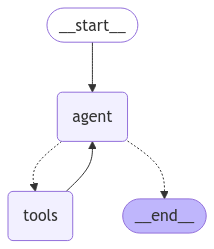

In [58]:
from IPython.display import Image, display


display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

system_prompt = """
You are the agent that reasons why stocks for particular company went up or down.
First step is to get the date when stock value changed the most. After that, query and analyze news for that company and reason why stocks have changed.
"""

inputs = {
    "messages": [
        ("system", system_prompt),
        ("user", "Analyze stock price changes for Google")
    ]
}
print_stream(agent.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Analyze stock price changes for Google
================================== Ai Message ==================================
Tool Calls:
  get_max_abs_price_diff_tool_lc (call_egun28zklpeedrvxok61sspl)
 Call ID: call_egun28zklpeedrvxok61sspl
  Args:
    ticker: GOOG
================================= Tool Message =================================
Name: get_max_abs_price_diff_tool_lc

2025-02-04
================================== Ai Message ==================================
Tool Calls:
  get_company_news_tool_lc (call_9ameovb0df7eif6yv46ueva5)
 Call ID: call_9ameovb0df7eif6yv46ueva5
  Args:
    company_name: Google
    date_to: 2025-02-04
================================= Tool Message =================================
Name: get_company_news_tool_lc

China Is Investigating Google Over Trump's Tariffs
Google's limited presence in China gives Beijing room to hit back harder if President Donald Trump’s trade war es